In [22]:
import os
import sys

def is_running_on_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def is_not_in_virtualenv():
    return hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix == sys.prefix)

def is_first_run():
    return not os.path.exists("/content/.colab_restarted")

if is_running_on_colab():
    if is_first_run():
        %pip install torch pandas matplotlib matplotlib opencv-python mediapipe
        with open("/content/.colab_restarted", "w") as f:
            f.write("Runtime restarted once")
        print('Restarting ...')
        os._exit(00)

elif is_not_in_virtualenv():
    %pip install torch pandas matplotlib matplotlib opencv-python mediapipe
    # %pip install poetry
    # !poetry config virtualenvs.create false --local
    # !poetry install --no-root
else:
    %pip install torch pandas matplotlib matplotlib opencv-python mediapipe
    # %pip install poetry
    # !poetry install --no-root


Note: you may need to restart the kernel to use updated packages.


In [23]:
##%%
import os
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Parameters
TEST_LIVE = not is_running_on_colab() # Toggle ON if the running environment has access to a camera
USE_PRETRAINED_MODEL = True
DATA_DIR = './data'
MODEL_PATH = f"{DATA_DIR}/sign_language_99_cnn.pth"
PERFORMANCE_PATH = f"{DATA_DIR}/training_stats.csv"
MODEL_URL = 'https://drive.google.com/file/d/1aUgeUFy-zpezbFWfMjDtPivatGOv1x5Y/view?usp=drive_link'
PERFORMANCE_URL = 'https://drive.google.com/file/d/1vTmCGOLeZtGbM1s7euyz36ejulmmfkIp/view?usp=drive_link'
DATA_URL = "https://www.kaggle.com/api/v1/datasets/download/datamunge/sign-language-mnist"

Learning_Rate = 0.01
Epochs = 100
confused = np.zeros((26, 26))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)
print("Setup complete.")


Device: cpu
Setup complete.


In [24]:

label_list = [chr(i) for i in range(65, 91)]

In [25]:
import os
import zipfile
import requests

os.makedirs(DATA_DIR,exist_ok=True)
ZIP_NAME = f"{DATA_DIR}/sign-language-mnist.zip"
CSV_FILES = [f"{DATA_DIR}/sign_mnist_train.csv", f"{DATA_DIR}/sign_mnist_test.csv"]

def download_and_extract():
    print("Downloading dataset...")
    with requests.get(DATA_URL, stream=True) as r:
        r.raise_for_status()
        with open(ZIP_NAME, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_NAME, 'r') as zip_ref:
        zip_ref.extractall(f"{DATA_DIR}/")

# Check for CSVs and download/extract if needed
if not all(os.path.exists(csv) for csv in CSV_FILES):
    download_and_extract()
else:
    print("CSV files already present.")

CSV files already present.


In [26]:
# This helps speed up data loading time across multiple runs (pkl > csv)
def preprocess_and_save(csv_path, pkl_path):
    df = pd.read_csv(csv_path)
    labels = df.iloc[:, 0].astype(np.int64).values
    images = df.iloc[:, 1:].astype(np.float32).values / 255.0
    images = images.reshape((-1, 1, 28, 28))

    with open(pkl_path, 'wb') as f:
        pickle.dump((images, labels), f)
    print(f"Saved to {pkl_path}")



preprocess_and_save(f"{DATA_DIR}/sign_mnist_train/sign_mnist_train.csv", f"{DATA_DIR}/train.pkl")
preprocess_and_save(f"{DATA_DIR}/sign_mnist_test/sign_mnist_test.csv", f"{DATA_DIR}/test.pkl")

Saved to ./data/train.pkl
Saved to ./data/test.pkl


In [27]:
##%%
class MNIST_Pickle_Dataset(Dataset):
    def __init__(self, pkl_file):
        with open(pkl_file, 'rb') as f:
            self.images, self.labels = pickle.load(f)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx]), torch.tensor(self.labels[idx])

train_Data = MNIST_Pickle_Dataset(f"{DATA_DIR}/train.pkl")
test_Data = MNIST_Pickle_Dataset(f"{DATA_DIR}/test.pkl")

loaders = {
    'train': DataLoader(train_Data, batch_size=32, shuffle=True),
    'test': DataLoader(test_Data, batch_size=32, shuffle=False),
}


In [28]:
# The Architecture
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers + BatchNorm
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2d = nn.Dropout2d(0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Adaptive Global Average Pooling to (1,1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 26)  # 26 classes for A-Z

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2d(x)

        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No log_softmax here!

        return x  # Will use CrossEntropyLoss externally

# Setup model, optimizer, loss
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=Learning_Rate)
loss_fn = nn.CrossEntropyLoss()

# # Optional scheduler to reduce LR on plateaus
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


In [29]:
# For saving the model & Resusing it
def save_model():
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")

def load_model():
    if os.path.exists(MODEL_PATH):
        checkpoint = torch.load(MODEL_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Model loaded.")
    else:
        print("No saved model found.")


In [30]:

def train(epoch):
    model.train()
    total_loss = 0
    for data, target in loaders['train']:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loaders['train'])

def test():
    global confused
    model.eval()
    test_loss = 0
    correct = 0
    confused.fill(0)

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1)
            for t, p in zip(target.cpu().numpy(), pred.cpu().numpy()):
                confused[t, p] += 1
            correct += (pred == target).sum().item()

    test_loss /= len(loaders['test'])
    accuracy = correct / len(loaders['test'].dataset)
    return accuracy, test_loss

In [31]:
# Plot Setup
import matplotlib.pyplot as plt

train_losses = []
test_accuracies = []

def record_metrics(train_loss, test_accuracy):
    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)


In [32]:
import requests
import re

def download_file_from_google_drive(url, destination):
    session = requests.Session()

    response = session.get(url, stream=True)
    file_id = re.findall(r'/d/([^/]+)', url)
    if not file_id:
        raise ValueError("Could not extract file ID from the URL.")

    download_url = f"https://drive.google.com/uc?export=download&id={file_id[0]}"
    response = session.get(download_url, stream=True)

    # Check for confirmation token (for large files)
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            download_url = f"https://drive.google.com/uc?export=download&confirm={value}&id={file_id[0]}"
            response = session.get(download_url, stream=True)
            break

    with open(destination, "wb") as f:
        for chunk in response.iter_content(32768):
            if chunk:
                f.write(chunk)


def ensure_file_downloaded(url, path):
    """Check if file exists, if not download it"""
    if not os.path.exists(path):
        print(f"Downloading {path}...")
        download_file_from_google_drive(url, path)
        print(f"Downloaded {path} successfully!")
    else:
        print(f"{path} already exists, skipping download.")

In [33]:
import pandas as pd
import os

if not USE_PRETRAINED_MODEL:
    for epoch in range(Epochs):
        train_loss = train(epoch)
        (test_accuracy,test_loss) = test()
        print(f"Epoch: {epoch}: Avg loss: {test_loss:.4f}, Accuracy: ({test_accuracy*100:.2f}%)")

        record_metrics(train_loss, test_accuracy)
        scheduler.step(test_accuracy)
        

        if test_accuracy >= 99.8:
            print(f" Early stopping: Reached {test_accuracy:.2f}% accuracy at epoch {epoch + 1}")
            break

    # Save the model after training
    performance_df = pd.DataFrame()
    performance_df['train_losses'] =  train_losses
    performance_df['test_accuracies']= test_accuracies
    performance_df.to_csv(PERFORMANCE_PATH, index=False)
    save_model()
else:

    # Load the performance data from the file
    ensure_file_downloaded(MODEL_URL, MODEL_PATH)
    load_model()
    test()

    ensure_file_downloaded(PERFORMANCE_URL, PERFORMANCE_PATH)
    performance_df = pd.read_csv(PERFORMANCE_PATH)
    train_losses = performance_df['train_losses'].astype(float).to_numpy()
    test_accuracies = performance_df['test_accuracies'].astype(float).to_numpy()


./data/sign_language_99_cnn.pth already exists, skipping download.
Model loaded.
./data/training_stats.csv already exists, skipping download.


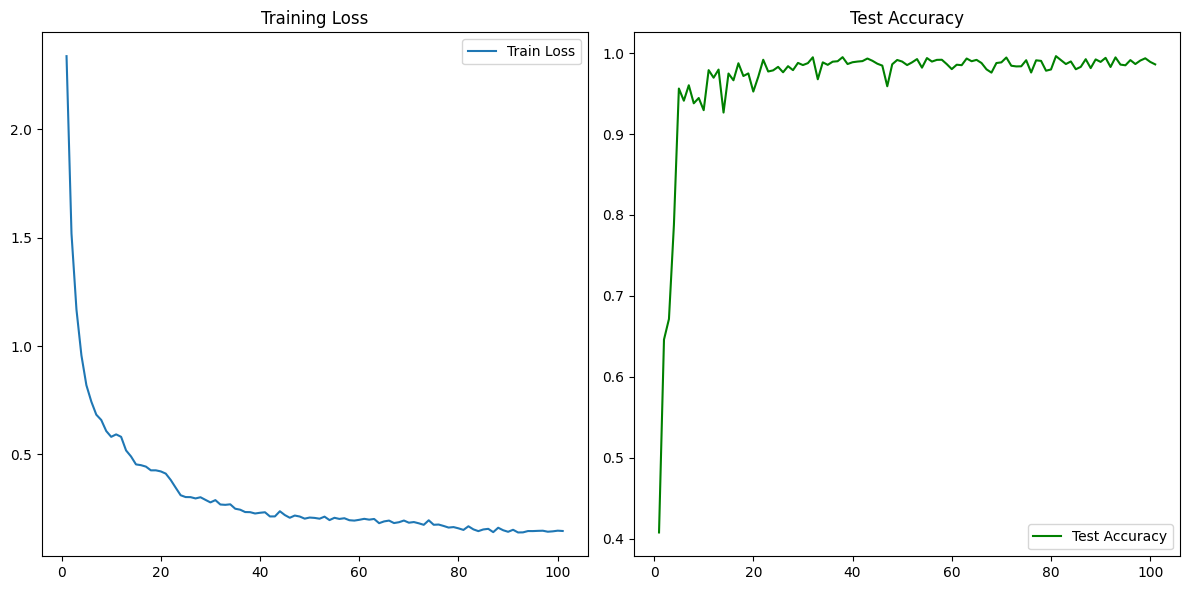

In [34]:

# Plot after training
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy', color='green')
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_110342/3495361971.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


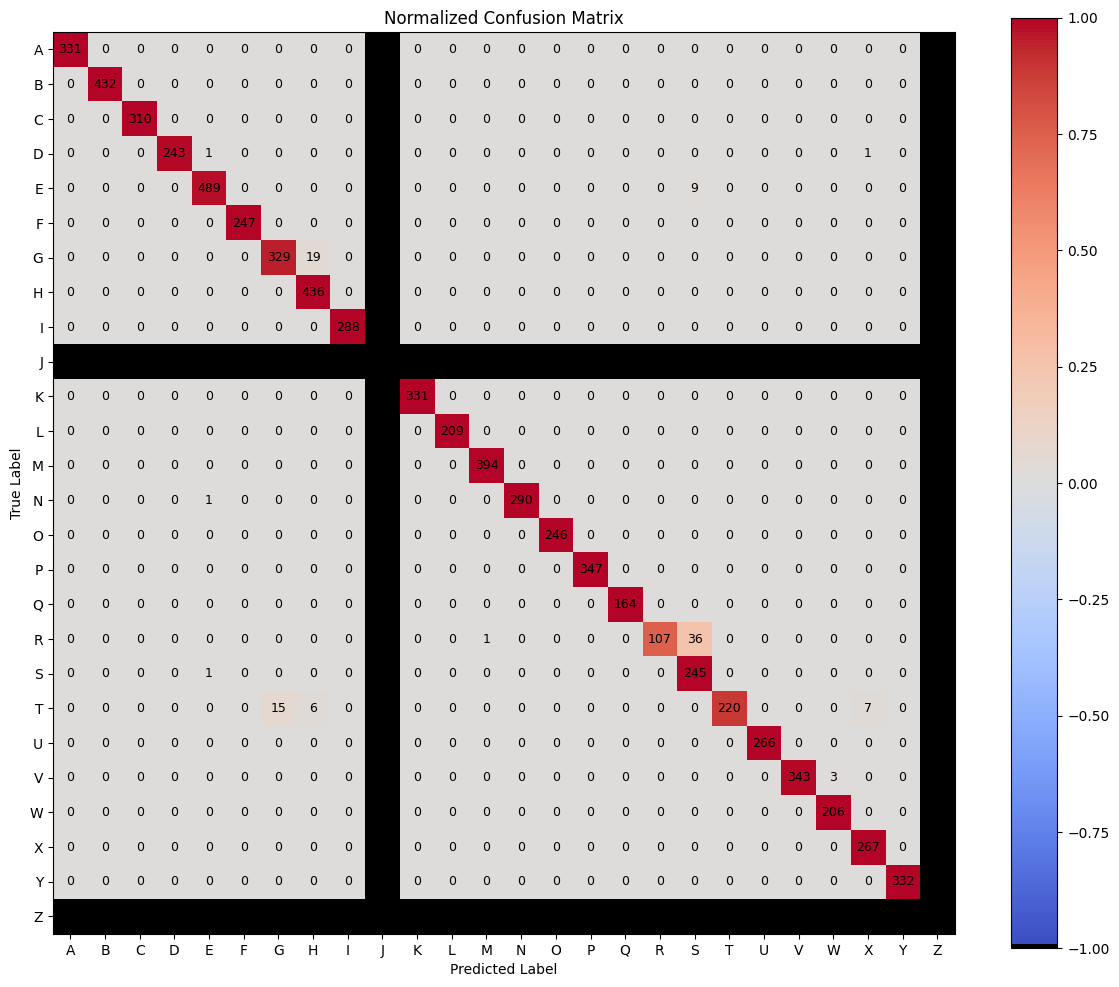

In [35]:

excluded_labels = ['J', 'Z']
excluded_indices = [label_list.index(l) for l in excluded_labels]

normalized_confusion = confused.astype(np.float32)
row_sums = normalized_confusion.sum(axis=1, keepdims=True)
normalized_confusion = np.divide(normalized_confusion, row_sums, out=np.zeros_like(normalized_confusion), where=row_sums != 0)

# black out excluded rows/cols visually
mask = np.ones_like(normalized_confusion)
for idx in excluded_indices:
    mask[idx, :] = 0
    mask[:, idx] = 0


display_matrix = np.where(mask == 1, normalized_confusion, -1)

plt.figure(figsize=(12, 10))

# Custom colormap with black for excluded
from matplotlib import cm
from matplotlib.colors import ListedColormap
cmap = cm.get_cmap('coolwarm')
new_colors = cmap(np.linspace(0, 1, 256))
new_colors[0] = [0, 0, 0, 1]  # RGBa for black
custom_cmap = ListedColormap(new_colors)

plt.imshow(display_matrix, interpolation='nearest', cmap=custom_cmap, vmin=-1, vmax=1)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Draw text only where not excluded
for i in range(26):
    for j in range(26):
        if i in excluded_indices or j in excluded_indices:
            continue
        count = confused[i, j]
        if count >= 0:
            plt.text(j, i, f'{int(count)}', ha='center', va='center', color='black', fontsize=9)

plt.xticks(np.arange(26), label_list)
plt.yticks(np.arange(26), label_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [36]:
from PIL import Image

#  crop boxes for letters(left, upper, right, lower)
hardcoded_boxes = [
    (9, 9, 99, 99),        # A
    (119, 9, 209, 99),     # B
    (229, 9, 319, 99),     # C
    (339, 9, 429, 99),     # D
    (449, 9, 539, 99),     # E
    (559, 9, 649, 99),     # F

    (9, 124, 99, 214),     # G
    (119, 124, 209, 214),  # H
    (229, 124, 319, 214),  # I
    # (339, 124, 429, 214),  # J
    (449-90-20, 124, 539-90-20, 214),  # K
    (559-90-20, 124, 649-90-20, 214),  # L

    (9, 239, 99, 329),     # M
    (119-90-20, 239, 209-90-20, 329),  # N
    (229-90-20, 239, 319-90-20, 329),  # O
    (339-90-20, 239, 429-90-20, 329),  # P
    (449-90-20, 239, 539-90-20, 329),  # Q
    (559-90-20, 239, 649-90-20, 329),  # R

    (9+90*6, 354-90-25, 99+90*6, 444+-90-25),     # S
    (119-90-20, 354, 209-90-20, 444),  # T
    (229-90-20, 354, 319-90-20, 444),  # U
    (339-90-20, 354, 429-90-20, 444),  # V
    (449-90-20, 354, 539-90-20, 444),  # W
    (559-90-20, 354, 649-90-20, 444),  # X

    (665-6-90, 471-6-90-20, 665-6,471-20),       # Y
    (665-6-90, 471-6-90-20, 665-6,471-20)      # Z
]

label_list = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # ['A', ..., 'Z']


large_image_path=f"{DATA_DIR}/amer_sign2.png"
def get_cropped_image(label):
    label_index = label_list.index(label)
    box = hardcoded_boxes[label_index]

    large_image = Image.open(large_image_path)
    cropped_image = large_image.crop(box)
    return cropped_image

import random

def get_misclassified_indexes(target_label, max_test_cases=4):
    model.eval()
    misclassified = []

    target_index = label_list.index(target_label)

    for idx, (data, target) in enumerate(test_Data):
        if target.item() != target_index:
            continue  # Only check samples with target label == target_label

        data = data.unsqueeze(0).to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        if pred.item() != target_index:
            misclassified.append(idx)

        if len(misclassified) >= max_test_cases:
            break  # Limit to max_test_cases

    return misclassified

def get_random_correctly_classified_indexes(target_label, max_test_cases=4):
    model.eval()
    correctly_classified = []

    target_index = label_list.index(target_label)

    # Track how many correctly classified cases we've found
    correct_count = 0

    while correct_count < max_test_cases:
        idx = random.randint(0, len(test_Data) - 1)  # Randomly select an index
        data, target = test_Data[idx]

        if target.item() == target_index:  # Only consider if the label matches target
            data = data.unsqueeze(0).to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            if pred.item() == target_index:  # Check if it was classified correctly
                correctly_classified.append(idx)
                correct_count += 1  # Increment count if classified correctly

    return correctly_classified


# Function to display multiple test images and their cropped reference images
def display_images(indexes):
    counter =0
    for index in indexes:
        model.eval()
        data, target = test_Data[index]
        data = data.unsqueeze(0).to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        image = data.squeeze().cpu().numpy()

        true_label = label_list[target.item()]
        pred_label = label_list[pred.item()]

        # Decide how many images to show based on whether prediction was wrong
        show_pred_ref = pred_label != true_label
        num_cols = 3 if show_pred_ref else 2

        plt.figure(figsize=(4 * num_cols, 4))

        # Test image
        plt.subplot(1, num_cols, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {true_label} | Pred: {pred_label}')
        plt.axis('off')

        # True label ref image
        cropped_true = get_cropped_image(true_label)
        plt.subplot(1, num_cols, 2)
        plt.imshow(cropped_true)
        plt.title(f'True Label: {true_label}')
        plt.axis('off')

        # Predicted label ref image (only if different)
        if show_pred_ref:
            cropped_pred = get_cropped_image(pred_label)
            plt.subplot(1, num_cols, 3)
            plt.imshow(cropped_pred)
            plt.title(f'Predicted Label: {pred_label}')
            plt.axis('off')

        counter+=1
        plt.tight_layout()
        plt.show()
    print(f"Showing {counter} test cases")

In [37]:
import random

def generate_random_indexes(N):
    return random.sample(range(7170), N)


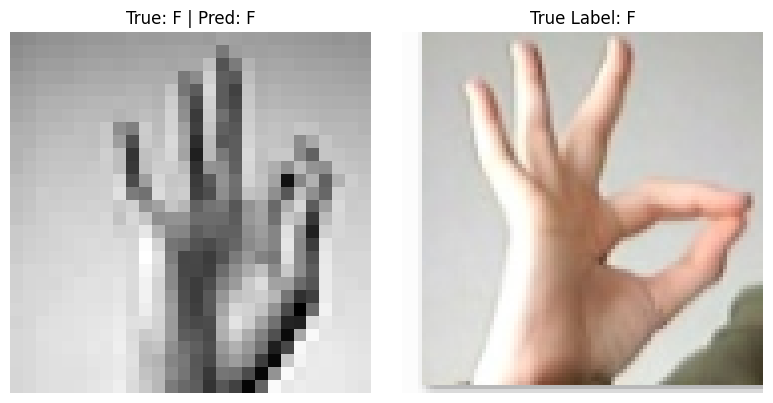

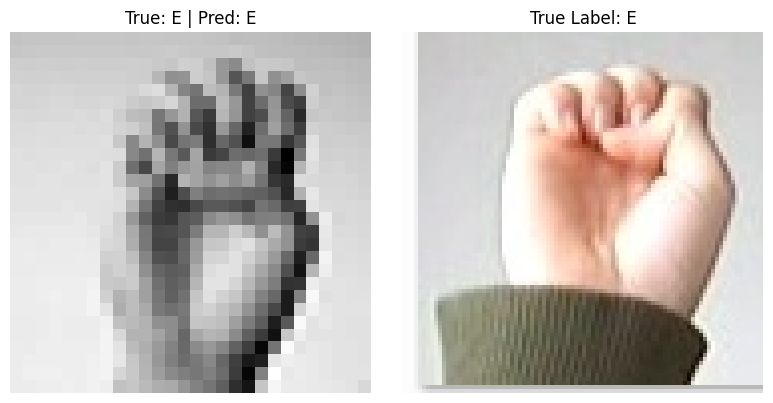

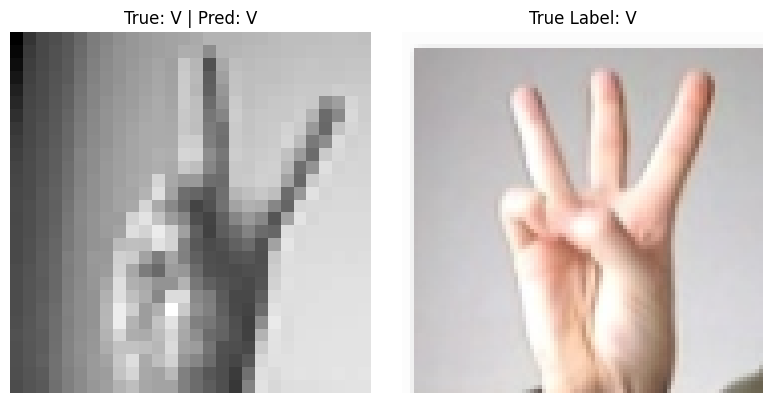

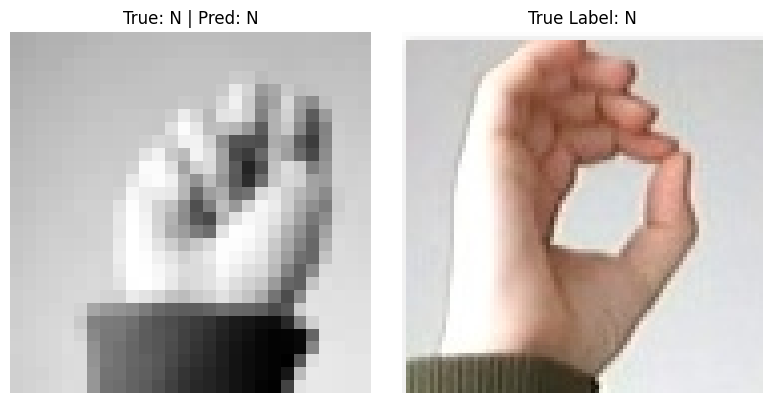

Showing 4 test cases


In [38]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Initial option selector
option_selector = widgets.Dropdown(
    options=['Random', 'Preset', 'Misclassified', 'Correctly Classified'],
    value='Preset',  # Default is 'Preset'
    description='Mode:'
)

# Misclassified letter selector, initially hidden
letter_selector = widgets.Dropdown(
    options=[chr(i) for i in range(ord('A'), ord('Z')) if chr(i) != 'Z'],
    description='Letter:',
    disabled=False,  # Initially enabled but won't show unless Misclassified is selected
    value='E'
)

# Place the two selectors side by side using HBox
selectors_box = widgets.HBox([option_selector, letter_selector])

# Function to update images based on the selection
def on_option_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_display(change['new'])

# Function to update images based on the selected letter (Misclassified mode)
def on_letter_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_display(option_selector.value)

# Function to handle the display and clearing
def run_display(mode):
    clear_output(wait=True)
    display(selectors_box)
    
    # Show letter selector only when 'Misclassified' is selected
    if mode == 'Misclassified' or mode == 'Correctly Classified':
        letter_selector.layout.display = 'inline-block'  # Show the letter selector
    else:
        letter_selector.layout.display = 'none'  # Hide the letter selector
    
    # Update the display based on the selected mode
    if mode == 'Random':
        indexes_to_test = generate_random_indexes(4)  # Fixed to 4 for Random mode
    elif mode == 'Preset':
        indexes_to_test = [1, 15, 7000, 61]
    elif mode == 'Misclassified' and letter_selector.value:
        indexes_to_test = get_misclassified_indexes(letter_selector.value)  # Get misclassified for selected letter
    elif mode == 'Correctly Classified' and letter_selector.value:
        indexes_to_test = get_random_correctly_classified_indexes(letter_selector.value)  # Get correctly classified for selected letter
    display_images(indexes_to_test)

# Observing the change in selection for both option and letter selector
option_selector.observe(on_option_change)
letter_selector.observe(on_letter_change)

# Initial run with default 'Preset' mode
run_display(option_selector.value)

In [39]:
import cv2
import mediapipe as mp
import torch
import numpy as np
import string
from collections import deque

def run_live_demo():
    # Configuration parameters
    HAND_SELECTOR_SENSITIVITY = 1.5  # Higher = larger hand selection are
    MIN_DETECTION_CONFIDENCE = 0.5   # Hand detection sensitivity (0-1)
    MIN_TRACKING_CONFIDENCE = 0.5     # Hand tracking sensitivity (0-1)
    LATERAL_INVERT = False           # Set to True to mirror the image
    PROBABILITY_WINDOW_SIZE = 30       # Number of frames to average predictions over

    # Initialize MediaPipe Hands with configurable sensitivity
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=MIN_DETECTION_CONFIDENCE,
        min_tracking_confidence=MIN_TRACKING_CONFIDENCE
    )

    # English alphabet letters
    LETTERS = list(string.ascii_lowercase)
    model.eval()

    # Dictionary to store probability windows for each hand
    hand_prob_windows = {}

    try:
        cap = cv2.VideoCapture(0)
        active_windows = set()
        main_window_open = True

        while cap.isOpened() and main_window_open:
            ret, frame = cap.read()
            if not ret:
                continue
            
            # Lateral inversion if enabled
            if LATERAL_INVERT:
                frame = cv2.flip(frame, 1)
            
            # Process frame
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)
            
            display_frame = frame.copy()
            current_hands = set()
            hand_images = []
            
            if results.multi_hand_landmarks:
                for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
                    # Get hand bounding box with adjustable sensitivity
                    landmarks = np.array([(lm.x * frame.shape[1], lm.y * frame.shape[0]) 
                                        for lm in hand_landmarks.landmark])
                    x_min, y_min = landmarks.min(axis=0)
                    x_max, y_max = landmarks.max(axis=0)
                    
                    # Make square region with configurable padding
                    side = max(x_max - x_min, y_max - y_min) * HAND_SELECTOR_SENSITIVITY
                    center_x, center_y = (x_min + x_max)/2, (y_min + y_max)/2
                    x_min, x_max = int(center_x - side/2), int(center_x + side/2)
                    y_min, y_max = int(center_y - side/2), int(center_y + side/2)
                    
                    # Clip coordinates
                    x_min, y_min = max(0, x_min), max(0, y_min)
                    x_max, y_max = min(frame.shape[1], x_max), min(frame.shape[0], y_max)
                    
                    # Extract and process hand region
                    hand_region = frame[y_min:y_max, x_min:x_max]
                    if hand_region.size > 0:
                        gray = cv2.cvtColor(hand_region, cv2.COLOR_BGR2GRAY)
                        resized = cv2.resize(gray, (28, 28))
                        hand_images.append((i, resized))
                        
                        # Draw bounding box with hand ID
                        cv2.rectangle(display_frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                        cv2.putText(display_frame, f"Hand {i}", (x_min, y_min - 10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                        current_hands.add(i)
            
            # Close windows for hands no longer visible
            for window_id in list(active_windows):
                if window_id not in current_hands:
                    cv2.destroyWindow(f"Hand {window_id}")
                    active_windows.remove(window_id)
                    # Remove probability window for disappeared hand
                    if window_id in hand_prob_windows:
                        del hand_prob_windows[window_id]
            
            # Process through model if hands detected
            if hand_images:
                # Prepare tensor [batch, channel, height, width]
                images = [img for (i, img) in hand_images]
                hand_tensors = torch.stack([
                    torch.from_numpy(img).float().unsqueeze(0)/255.0 
                    for img in images
                ])
                            
                with torch.no_grad():
                    outputs = model(hand_tensors)
                    probabilities = torch.softmax(outputs, dim=1)
                
                # Update probability windows and display results
                for (i, img), prob in zip(hand_images, probabilities):
                    # Initialize probability window for new hands
                    if i not in hand_prob_windows:
                        hand_prob_windows[i] = deque(maxlen=PROBABILITY_WINDOW_SIZE)
                    
                    # Add current probabilities to the window
                    hand_prob_windows[i].append(prob)
                    
                    # Calculate average probabilities over the window
                    avg_probs = torch.mean(torch.stack(list(hand_prob_windows[i])), dim=0)
                    
                    # Get top predictions from averaged probabilities
                    probs, indices = torch.topk(avg_probs, 3)
                    top_letters = [LETTERS[idx] for idx in indices]
                    
                    # Create display image
                    display_img = cv2.resize(img, (280, 280), interpolation=cv2.INTER_NEAREST)
                    display_img = cv2.cvtColor(display_img, cv2.COLOR_GRAY2BGR)
                    
                    # Display top 3 predictions with window size info
                    # cv2.putText(display_img, f"Window: {len(hand_prob_windows[i])}/{PROBABILITY_WINDOW_SIZE}", 
                    #             (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                    
                    for j, (letter, prob) in enumerate(zip(top_letters, probs)):
                        y_pos = 50 + j * 30
                        cv2.putText(display_img, f"{letter}: {prob:.2f}", 
                                    (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 
                                    (0, 0, 255), 2)
                    
                    # Create or update hand window
                    if i not in active_windows:
                        cv2.namedWindow(f"Hand {i}", cv2.WINDOW_AUTOSIZE)
                        active_windows.add(i)
                    
                    cv2.imshow(f"Hand {i}", display_img)
            
            # Display main view
            cv2.imshow("Hand Tracking", display_frame)
            
            # Check for window close events or 'q' press
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
                
            # Check if main window was closed
            if cv2.getWindowProperty("Hand Tracking", cv2.WND_PROP_VISIBLE) < 1:
                main_window_open = False

    except Exception as e:
        print(f"Error occurred: {str(e)}")

    finally:
        # Clean up all windows
        for window_id in active_windows:
            cv2.destroyWindow(f"Hand {window_id}")
        cv2.destroyAllWindows()
        if 'cap' in locals():
            cap.release()
        if 'hands' in locals():
            hands.close()
        print("Resources released successfully")

if TEST_LIVE: 
    run_live_demo()

I0000 00:00:1745862959.811200  110342 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745862959.815220  111534 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.3-1), renderer: Mesa Intel(R) Iris(R) Xe Graphics (TGL GT2)
W0000 00:00:1745862959.844825  111527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745862959.875493  111531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Resources released successfully
